## 计算不同策略下拓扑更新，绘制相关实验结果图

In [1]:
import numpy as np
import pandas as pd
import math
#from tletools import TLE
import time
import datetime
import matplotlib.pyplot as plt
import statsmodels.api as sm
import csv
from skyfield.api import load, wgs84
from skyfield.api import EarthSatellite
from skyfield.elementslib import OsculatingElements
from skyfield.data import spice

In [2]:
constellation = "starlink"
path = "../../tle/"
max_isl = 4782.174752610824

#### 位置信息处理

In [3]:
cbf_file = path + constellation + "_u_pos_cbf_3_month.npy"
pos_file = path + constellation + "_u_pos_3_month.npy"
ext_file = path + constellation + "_u_extend_m_3_month.npy"
vel_file = path + constellation + "_u_velocity_3_month.npy"

pos_cbf=np.load(cbf_file,allow_pickle=True).tolist()
print(type(pos_cbf[0][0][0]))
print(pos_cbf[0][0])
print(np.shape(pos_cbf))

pos=np.load(pos_file,allow_pickle=True).tolist()
print(type(pos[0][0][0]))
print(pos[0][0])
print(np.shape(pos))

extend_m = np.load(ext_file,allow_pickle=True).tolist()
print(type(extend_m[0][0][0]))
print(extend_m[0][0])
print(np.shape(extend_m))

velocity = np.load(vel_file,allow_pickle=True).tolist()
print(type(velocity[0][0][0]))
print(velocity[0][0])
print(np.shape(velocity))

<class 'float'>
[-6053.995926609168, -874.6018578643767, 3238.421525132463]
(1686, 15840, 3)
<class 'float'>
[27.923081914311325, -0.8406291481134366, 547.7352901960046]
(1686, 15840, 3)
<class 'float'>
[84.86641998843886, 311.07243633325197, 164.79065562627238, 6927.731917274687]
(1686, 144, 4)
<class 'float'>
[3.3243790438689476, -4.732348547617833, 4.919057534542607]
(1686, 15840, 3)


In [4]:
# 筛选过滤后卫星对应的位置信息
def read_txt(file):
    r = []
    with open(file,"r") as f:
        line = f.readline()
        while line:
            r.append(int(line.strip('\n')))
            line = f.readline()
    return r
f_keys = read_txt("../../tle/data/filtered_index.txt")
print(len(f_keys))

def filter_pos():
    r, rr, ee, v = [], [], [], []
    for item in f_keys:
        r.append(pos_cbf[item])
        rr.append(pos[item])
        ee.append(extend_m[item])
        v.append(velocity[item])
    return r, rr, ee, v
pos_cbf, pos, extend_m, velocity = filter_pos()
print(np.shape(pos_cbf), np.shape(pos), np.shape(extend_m), np.shape(velocity))

node_num = len(pos)
cycle = len(pos[0])

1541
(1541, 15840, 3) (1541, 15840, 3) (1541, 144, 4) (1541, 15840, 3)


#### 卫星id读取

In [5]:
file = "../../tle/data/filtered_3_month.csv"
# file = "./data/sat_3_month.csv"
df = pd.read_csv(file,header=None,sep='\t')
data = df[0].str.split(',').values.tolist()
print(np.shape(data), data[0])
node_num = len(data)

tle_file = path + "tle_starlink_3_month_0401_0712.npy"
tle_data = np.load(tle_file, allow_pickle=True)
print("type: ", type(tle_data.item()))
tle_item = tle_data.item()
print("type: ", type(tle_item))
tle = tle_item.items()
d = {}
for k,v in tle:
    d[k] = v # v是多维的，两个月左右的数据，采样粒度可能有区别
print("Total: ",len(d), d['47150'][0])

keys = [item[0] for item in data]
print("Number of satellite: ", len(keys))

(1541, 2) ['44713', '19074A']
type:  <class 'dict'>
type:  <class 'dict'>
Total:  1701 ['2022-04-01 05:20:18', '1 47150U 20088AE  22091.22243163  .00004265  00000-0  30493-3 0  9991', '2 47150  53.0541 269.1438 0001347  72.7409 287.3727 15.06410475 75421', '6925.316']
Number of satellite:  1541


####  0时刻运行方向计算（仅一开始需要执行）

In [6]:
# 60秒传播结果，用于运行方向判定
cbf_file = path + "second_pos_cbf_3_month.npy"
pos_file = path + "second_pos_3_month.npy"

spos_cbf=np.load(cbf_file,allow_pickle=True).tolist()
print(type(spos_cbf[0][0][0]))
print(spos_cbf[0][0])
print(np.shape(spos_cbf))

spos=np.load(pos_file,allow_pickle=True).tolist()
print(type(spos[0][0][0]))
print(spos[0][0])
print(np.shape(spos))

def filter_pos():
    r, rr = [], []
    for item in f_keys:
        r.append(spos_cbf[item])
        rr.append(spos[item])
    return r, rr
spos_cbf, spos = filter_pos()
print(np.shape(spos_cbf), np.shape(spos))

<class 'float'>
[-6053.995926609168, -874.6018578643767, 3238.421525132463]
(1686, 60, 3)
<class 'float'>
[27.923081914311325, -0.8406291481134366, 547.7352901960046]
(1686, 60, 3)
(1541, 60, 3) (1541, 60, 3)


In [7]:
# 卫星运行方向计算
def sat_direction(t):
    r = []
    for i in range(node_num):
        z1 = spos_cbf[i][t][2]
        z2 = spos_cbf[i][t+1][2]
        if z2 >= z1:
            r.append(1)  # north
        else:
            r.append(-1)  # south
    return r

sat_dir = sat_direction(0)
print("shape: ", len(sat_dir))
#np.save("./data/sat_dir_3_month.npy", sat_dir)

shape:  1541


#### 推测卫星在轨道内的分布 (经度) （仅一开始需要执行）

In [8]:
# 推测（只在算的时候执行）
def infer_orbit():
    dd = {}
    for i in range(node_num): # node_num对应筛选后的卫星数，因此extend_m需要修改
        t = 0
        raan = int(round(extend_m[i][t][2], 0))
        if raan not in dd:
            dd[raan] = [keys[i]]
        else:
            dd[raan].append(keys[i])
    return dd

orbits = infer_orbit()
print("total orbits: ", len(orbits))
orbit_kk = sorted(orbits.keys())
print("sorted raan: ", orbit_kk)

orbit_filtered = {}
for i in range(5,365,5): # modify
# for i in orbits:
    #if len(orbits[i]) > 10:
    orbit_filtered[i] = orbits[i]
print("orbit num: ", len(orbit_filtered))

summ, sat_per_orbit = 0, []
for key in orbit_filtered:
    summ += len(orbit_filtered[key])
    sat_per_orbit.append(len(orbit_filtered[key]))
print("satellite num: ", summ)
print("satellite per orbit: ", min(sat_per_orbit), max(sat_per_orbit))

# def filter_by_altitude(dd):
#     t = 0
#     for key in dd:
#         tmp = dd[key]
#         alts = [pos[keys.index(i)][t][-1] for i in tmp]
#         print(alts)
# filter_by_altitude(orbit_filtered)
    

filtered_sat = [[key, len(orbit_filtered[key])] for key in orbit_filtered]

def save_txt(dd):
    r = []
    count = 0
    for key in dd:
        count += 1
        for item in dd[key]:
            r.append([count,key, item]) # index from 1
    print(np.shape(r))
    with open("../../tle/data/sat_orbits_filtered_3_month.csv","w") as csvfile: 
        writer = csv.writer(csvfile)
        writer.writerow(["No.orbit","raan","sat"])
        writer.writerows(r)
#save_txt(orbit_filtered)

total orbits:  82
sorted raan:  [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 127, 130, 135, 137, 140, 145, 150, 155, 157, 160, 165, 166, 170, 175, 180, 185, 187, 190, 195, 197, 200, 205, 207, 210, 215, 220, 225, 227, 230, 235, 237, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 287, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360]
orbit num:  72
satellite num:  1409
satellite per orbit:  16 22


#### 读取卫星轨道信息，基于0时刻经度+方向对卫星排序

In [9]:
# 读入卫星所在轨道信息
file = "../../tle/data/sat_orbits_filtered_3_month.csv"
df = pd.read_csv(file,header=None,sep='\t')
df.drop(labels=None,axis=0, index=0, columns=None, inplace=True)
sat_data = df[0].str.split(',').values.tolist()
print(np.shape(sat_data), sat_data[0])

filtered_keys = []
for item in sat_data:
    filtered_keys.append(item[-1])
print(len(filtered_keys))

def establish_dict():
    d = {}
    for item in sat_data:
        d[item[-1]] = int(item[0])
    return d
name2orbit = establish_dict()
print(len(name2orbit))

def read_sat_orbit():
    d = {}
    for i in range(len(sat_data)):
        if int(sat_data[i][0]) not in d:
            d[int(sat_data[i][0])] = [keys.index(sat_data[i][2])]
        else:
            d[int(sat_data[i][0])].append(keys.index(sat_data[i][2]))
    return d
sat_orbit = read_sat_orbit()
print(len(sat_orbit), sat_orbit[1])

(1409, 3) ['1', '5', '45182']
1409
1409
72 [145, 147, 160, 161, 162, 163, 164, 166, 167, 168, 169, 170, 171, 172, 184, 747, 753, 785]


In [10]:
# 每个轨道内卫星根据经度排序
def sort_sat_lon(t):
    rr = []
    for o in sat_orbit:
        r = []
        for sat in sat_orbit[o]:
            lon = pos[sat][t][1]
            r.append([sat, lon])
        r = sorted(r, key = lambda x: x[1])
        r = [item[0] for item in r]
        rr.append(r)
    return rr
sorted_sat = sort_sat_lon(0)
print(np.shape(sorted_sat), sorted_sat[0])

(72,) [753, 161, 160, 167, 172, 164, 169, 747, 147, 163, 145, 184, 170, 171, 168, 166, 162, 785]


In [11]:
# 确定所有轨道0号卫星
sat_dir = np.load("../../tle/data/sat_dir_3_month.npy", allow_pickle=True).tolist()
print("sat direction shape: ", len(sat_dir))
def sat_0(t):
    max_isl = 4782.174752610824
    rr = []
    for o in range(len(sorted_sat)):
        r = []
        for sat in sorted_sat[o]:
            if sat_dir[sat] == 1:
                r.append([sat, abs(0 - pos[sat][t][0])])
        r = sorted(r, key = lambda x: x[1])
        sat0 = r[0][0]
        rr.append(sat0)
    return rr
sat0 = sat_0(0)
print("initial satellite: ", sat0, len(sat0))

def is_connected(t):
    flag = False
    for i in range(len(sat0)):
        x1, y1, z1 = pos_cbf[sat0[i]][t][0], pos_cbf[sat0[i]][t][1], pos_cbf[sat0[i]][t][2]
        x2, y2, z2 = pos_cbf[sat0[i-1]][t][0], pos_cbf[sat0[i-1]][t][1], pos_cbf[sat0[i-1]][t][2]
        dis = ((x1-x2)**2 + (y1-y2)**2 + (z1-z2)**2) ** 0.5
        dir1, dir2 = sat_dir[sat0[i]], sat_dir[sat0[i-1]]
        if dis < max_isl and dir1 == dir2:
            flag = True
        if not flag:
            return False
    return True
print(is_connected(0))    

sat direction shape:  1541
initial satellite:  [785, 792, 345, 852, 159, 899, 329, 745, 306, 871, 290, 1162, 273, 1195, 451, 1212, 249, 1404, 423, 1383, 412, 1341, 235, 1358, 598, 1126, 590, 580, 215, 1136, 562, 1281, 1295, 1311, 359, 908, 34, 913, 373, 1010, 940, 970, 365, 646, 134, 994, 638, 981, 1019, 1033, 499, 704, 100, 718, 497, 1086, 702, 1077, 459, 668, 75, 542, 675, 1265, 1248, 1240, 524, 1215, 179, 822, 535, 833] 72
True


In [12]:
# 再次排序,0号卫星在左侧
def sort_sat0():
    r = []
    for i in range(len(sorted_sat)):
        tmp = sorted_sat[i]
        ini = tmp.index(sat0[i])
        tmp1, tmp2 = tmp[:ini], tmp[ini:]
        tmp2.extend(tmp1)
        r.append(tmp2)
    return r
sorted_sat_0 = sort_sat0()
print(len(sorted_sat), sorted_sat[20])
# [270, 1406, 267, 284, 265, 263, 259, 262, 260, 258, 274, 272, 275, 264, 273, 271, 268, 269, 261]
# [1159, 1160, 1161, 1162, 1163, 1164, 1165, 1166, 1167, 1168, 1169, 1170, 1171, 1172, 1173, 1174, 1175, 1176]

72 [411, 414, 410, 409, 412, 413, 407, 406, 421, 417, 416, 404, 420, 405, 418, 403, 419, 408, 415, 914]


#### 初始时刻拓扑 （Grid和Sharing对应两种不同轨间计算方式）

In [13]:
# 初始时刻拓扑生成
def infer_topo(t, flag_i):
    r = [[0]*node_num for _ in range(node_num)]
    d_intra, d_inter = {}, {}
    have_neigh = [[-1, -1] for _ in range(node_num)] # node_num * 2 [intra_r, inter_r]
    # intra
    intra = 0
    for items in sorted_sat_0: # 遍历所有轨道
        tmp = items
        # print(tmp)
        for i in range(len(tmp)):
            x1, y1, z1 = pos_cbf[tmp[i]][t][0], pos_cbf[tmp[i]][t][1], pos_cbf[tmp[i]][t][2]
            nextt = tmp[(i+1)%len(tmp)]
            x2, y2, z2 = pos_cbf[nextt][t][0], pos_cbf[nextt][t][1], pos_cbf[nextt][t][2]
            dis = ((x1-x2)**2 + (y1-y2)**2 + (z1-z2)**2) ** 0.5
            if dis <= max_isl:
                have_neigh[tmp[i]][0] = 1
                r[tmp[i]][nextt] = 1
                r[nextt][tmp[i]] = 1
                if tmp[i] not in d_intra:
                    d_intra[tmp[i]] = [nextt]
                else:
                    d_intra[tmp[i]].append(nextt)
                if nextt not in d_intra:
                    d_intra[nextt] = [tmp[i]]
                else:
                    d_intra[nextt].append(tmp[i])
                intra += 1
    print("intra ISL: ", intra)
    
    # inter
    inter = 0
    if flag_i == "Sharing":
        for o in range(len(sorted_sat_0)):
            neighs = sorted_sat_0[(o+1)%72] # 相邻轨道所有卫星
            for sat in sorted_sat_0[o]: # 遍历当前轨道内卫星
                x1, y1, z1 = pos_cbf[sat][t][0], pos_cbf[sat][t][1], pos_cbf[sat][t][2]
                minn, index = float('inf'), -1
                for neigh in neighs:
                    x2, y2, z2 = pos_cbf[neigh][t][0], pos_cbf[neigh][t][1], pos_cbf[neigh][t][2]
                    dis = ((x1-x2)**2 + (y1-y2)**2 + (z1-z2)**2) ** 0.5
                    if dis <= max_isl and dis < minn:
                        minn = dis
                        index = neigh
                if index != -1: # 存在最近的可连接的邻轨卫星
                    r[sat][index] = 1
                    r[index][sat] = 1
                    have_neigh[sat][1] = 1
                    flag = True
                    if sat not in d_inter:
                        d_inter[sat] = [index]
                    else:
                        if index not in d_inter[sat]:
                            d_inter[sat].append(index)
                        else:
                            flag = False
                    if index not in d_inter:
                        d_inter[index] = [sat]
                    else:
                        if sat not in d_inter[index]:
                            d_inter[index].append(sat)
                        else:
                            flag = False
                    if flag:
                        inter += 1
    elif flag_i == "Grid":
        for o in range(len(sorted_sat_0)): # 遍历所有轨道
            sats1, sats2 = sorted_sat_0[o], sorted_sat_0[(o+1)%72] # 当前轨道和右侧轨道
            i, j = 0, 0
            while i < len(sats1) and j < len(sats2):
                x1, y1, z1 = pos_cbf[sats1[i]][t][0], pos_cbf[sats1[i]][t][1], pos_cbf[sats1[i]][t][2]
                x2, y2, z2 = pos_cbf[sats2[j]][t][0], pos_cbf[sats2[j]][t][1], pos_cbf[sats2[j]][t][2]
                dis = ((x1-x2)**2 + (y1-y2)**2 + (z1-z2)**2) ** 0.5
                # dir1, dir2 = sat_dir[sats1[i]], sat_dir[sats2[j]]
                if dis <= max_isl: #  and dir1 == dir2
                    have_neigh[sats1[i]][1] = 1
                    r[sats1[i]][sats2[j]] = 1
                    r[sats2[j]][sats1[i]] = 1
                    if sats1[i] not in d_inter:
                        d_inter[sats1[i]] = [sats2[j]]
                    else:
                        d_inter[sats1[i]].append(sats2[j])
                    if sats2[j] not in d_inter:
                        d_inter[sats2[j]] = [sats1[i]]
                    else:
                        d_inter[sats2[j]].append(sats1[i])
                    inter += 1
                    i += 1
                    j += 1
                else:
                    # gap = abs(pos[sats1[i]][t][0] - pos[sats2[j]][t][0])
                    if i+1 < len(sats1):
                        x1, y1, z1 = pos_cbf[sats1[i+1]][t][0], pos_cbf[sats1[i+1]][t][1], pos_cbf[sats1[i+1]][t][2]
                        x2, y2, z2 = pos_cbf[sats2[j]][t][0], pos_cbf[sats2[j]][t][1], pos_cbf[sats2[j]][t][2]
                        dis_i = ((x1-x2)**2 + (y1-y2)**2 + (z1-z2)**2) ** 0.5
                    if j+1 < len(sats2):
                        x1, y1, z1 = pos_cbf[sats1[i]][t][0], pos_cbf[sats1[i]][t][1], pos_cbf[sats1[i]][t][2]
                        x2, y2, z2 = pos_cbf[sats2[j+1]][t][0], pos_cbf[sats2[j+1]][t][1], pos_cbf[sats2[j+1]][t][2]
                        dis_j = ((x1-x2)**2 + (y1-y2)**2 + (z1-z2)**2) ** 0.5
                    if dis_i <= dis_j: # abs(pos[sats1[i]][t][0] - pos[sats2[j+1]][t][0]) < gap:
                        i += 1
                    else:
                        j += 1
                
    print("inter ISL: ", inter)
    print(d_intra[753])
    
    # 0轨道处理
    for sat in sorted_sat_0[0]:
#         if i == 0 and if have_neigh[sat][0] == 1:
#             d_intra[sat] = d_intra[sat][1:] + [d_intra[sat][0]]
        if have_neigh[sat][1] == 1:
            d_inter[sat] = d_inter[sat][1:] + [d_inter[sat][0]]
            
    # 所有轨道0号卫星处理
    for sats in sorted_sat_0:
        sat = sats[0]
        if have_neigh[sat][0] == 1:
            d_intra[sat] = d_intra[sat][1:] + [d_intra[sat][0]]
            
    print(d_intra[753])
            
    return r, d_intra, d_inter, have_neigh

topo0, intra, inter, have_neigh = infer_topo(0, "Grid")
print(np.shape(topo0), len(intra), len(inter), np.shape(have_neigh))

intra ISL:  1406
inter ISL:  1356
[785, 161]
[785, 161]
(1541, 1541) 1409 1389 (1541, 2)


In [14]:
# 测试
lenn = []
for kk in inter:
    lenn.append(len(inter[kk]))
print(sum(lenn)/2)


i = keys.index('45568')
i = 753
print(i)
nei = [item for item in inter[i]]
print(nei)
# print(keys[1294], name2orbit['48353'])
print(name2orbit[keys[sorted_sat_0[(0+1)%72][0]]])

1356.0
753
[837, 773]
2


### 拓扑改变分析 (关键代码)

In [15]:
# 邻居关系改变统计, 每当最短距离卫星发生改变就改变
# 每个时刻重新计算连接关系，即始终寻找最近邻居
def cal_topology_np(flag_i):
    topo0, intra, inter, have_neigh = infer_topo(0, flag_i)
    print(np.shape(topo0), len(intra), len(inter))
    r = []
    cycle = len(pos[0])
    pre_intra, pre_inter = intra, inter # t=0
    # sorted_sat0 = sort_sat_lon(0)
    
    for t in range(1, cycle):
        d_intra, d_inter = {}, {}
        sorted_sat = sort_sat_lon(t)
        # intra
        for items in sorted_sat: # 遍历所有轨道
            tmp = items
            for i in range(len(tmp)):
                x1, y1, z1 = pos_cbf[tmp[i]][t][0], pos_cbf[tmp[i]][t][1], pos_cbf[tmp[i]][t][2]
                nextt = tmp[(i+1)%len(tmp)]
                x2, y2, z2 = pos_cbf[nextt][t][0], pos_cbf[nextt][t][1], pos_cbf[nextt][t][2]
                dis = ((x1-x2)**2 + (y1-y2)**2 + (z1-z2)**2) ** 0.5
                if dis <= max_isl:
                    if tmp[i] not in d_intra:
                        d_intra[tmp[i]] = [nextt]
                    else:
                        d_intra[tmp[i]].append(nextt)
                    if nextt not in d_intra:
                        d_intra[nextt] = [tmp[i]]
                    else:
                        d_intra[nextt].append(tmp[i])

        # inter
        if flag_i == "Sharing":
            for o in range(len(sorted_sat)):
                neighs = sorted_sat[(o+1)%72]
                for sat in sorted_sat[o]:
                    x1, y1, z1 = pos_cbf[sat][t][0], pos_cbf[sat][t][1], pos_cbf[sat][t][2]
                    minn, index = float('inf'), -1
                    for neigh in neighs:
                        x2, y2, z2 = pos_cbf[neigh][t][0], pos_cbf[neigh][t][1], pos_cbf[neigh][t][2]
                        dis = ((x1-x2)**2 + (y1-y2)**2 + (z1-z2)**2) ** 0.5
                        if dis <= max_isl and dis < minn:
                            minn = dis
                            index = neigh
                    if index != -1:
                        if sat not in d_inter:
                            d_inter[sat] = [index]
                        else:
                            if index not in d_inter[sat]:
                                d_inter[sat].append(index)
                        if index not in d_inter:
                            d_inter[index] = [sat]
                        else:
                            if sat not in d_inter[index]:
                                d_inter[index].append(sat)
        elif flag_i == "Grid":
            for o in range(len(sorted_sat_0)): # 遍历所有轨道
                sats1, sats2 = sorted_sat_0[o], sorted_sat_0[(o+1)%72] # 当前轨道和右侧轨道
                i, j = 0, 0
                while i < len(sats1) and j < len(sats2):
                    x1, y1, z1 = pos_cbf[sats1[i]][t][0], pos_cbf[sats1[i]][t][1], pos_cbf[sats1[i]][t][2]
                    x2, y2, z2 = pos_cbf[sats2[j]][t][0], pos_cbf[sats2[j]][t][1], pos_cbf[sats2[j]][t][2]
                    dis = ((x1-x2)**2 + (y1-y2)**2 + (z1-z2)**2) ** 0.5
                    # dir1, dir2 = sat_dir[sats1[i]], sat_dir[sats2[j]]
                    if dis <= max_isl: #  and dir1 == dir2
                        if sats1[i] not in d_inter:
                            d_inter[sats1[i]] = [sats2[j]]
                        else:
                            d_inter[sats1[i]].append(sats2[j])
                        if sats2[j] not in d_inter:
                            d_inter[sats2[j]] = [sats1[i]]
                        else:
                            d_inter[sats2[j]].append(sats1[i])
                        i += 1
                        j += 1
                    else:
                        if i+1 < len(sats1):
                            x1, y1, z1 = pos_cbf[sats1[i+1]][t][0], pos_cbf[sats1[i+1]][t][1], pos_cbf[sats1[i+1]][t][2]
                            x2, y2, z2 = pos_cbf[sats2[j]][t][0], pos_cbf[sats2[j]][t][1], pos_cbf[sats2[j]][t][2]
                            dis_i = ((x1-x2)**2 + (y1-y2)**2 + (z1-z2)**2) ** 0.5
                        if j+1 < len(sats2):
                            x1, y1, z1 = pos_cbf[sats1[i]][t][0], pos_cbf[sats1[i]][t][1], pos_cbf[sats1[i]][t][2]
                            x2, y2, z2 = pos_cbf[sats2[j+1]][t][0], pos_cbf[sats2[j+1]][t][1], pos_cbf[sats2[j+1]][t][2]
                            dis_j = ((x1-x2)**2 + (y1-y2)**2 + (z1-z2)**2) ** 0.5
                        if dis_i <= dis_j: # abs(pos[sats1[i]][t][0] - pos[sats2[j+1]][t][0]) < gap:
                            i += 1
                        else:
                            j += 1
        
        flag1, flag2 = False, False
        for key in pre_intra:
            tmp1 = set(pre_intra[key])
            if key in d_intra:
                tmp2 = set(d_intra[key])
                if tmp1 != tmp2:
                    flag1 = True # intra change
                    break
            else:
                flag1 = True # intra change
                break
        if not flag1:
            for key in pre_inter:
                tmp1 = set(pre_inter[key])
                if key in d_inter:
                    tmp2 = set(d_inter[key])
                    if tmp1 != tmp2:
                        flag2 = True # inter change
                        break
                else:
                    flag2 = True # inter change
                    break
        pre_intra, pre_inter = d_intra, d_inter
        if flag1 or flag2:
            r.append(t)
            
        if t % 1000 == 0:   
            print("done: ", t)
    return r

In [16]:
# 邻居关系改变统计, 每当之前卫星连不上才改变
# 每个时刻重新计算连接关系，即始终寻找最近邻居
def cal_topology_p(flag_i):
    topo0, intra, inter, have_neigh = infer_topo(0, flag_i)
    print(np.shape(topo0), len(intra), len(inter))
    r = set()
    cycle = len(pos[0])
    pre_intra, pre_inter = intra, inter # t=0
    # sorted_sat0 = sort_sat_lon(0)
    
    for t in range(1, cycle):
        sorted_sat = sort_sat_lon(t) # 当前时刻卫星按经度排序
        # intra
        for o in range(len(sorted_sat)): # per orbit
            items = sorted_sat[o]
            tmp = items
            for i in range(len(tmp)):
                x1, y1, z1 = pos_cbf[tmp[i]][t][0], pos_cbf[tmp[i]][t][1], pos_cbf[tmp[i]][t][2] # 当前卫星
                if have_neigh[tmp[i]][0] != -1: 
                    neighs = pre_intra[tmp[i]]
                    neigh = neighs[-1]
                    x2, y2, z2 = pos_cbf[neigh][t][0], pos_cbf[neigh][t][1], pos_cbf[neigh][t][2]
                    dis = ((x1-x2)**2 + (y1-y2)**2 + (z1-z2)**2) ** 0.5
                    if dis > max_isl: # 无法继续连接
                        r.add(t)
                        x2, y2, z2 = pos_cbf[tmp[i-1]][t][0], pos_cbf[tmp[i-1]][t][1], pos_cbf[tmp[i-1]][t][2]
                        dis = ((x1-x2)**2 + (y1-y2)**2 + (z1-z2)**2) ** 0.5
                        if dis <= max_isl: # 更换
                            pre_intra[tmp[i]][-1] = tmp[i-1] 
                        else: # 删除
                            pre_intra[tmp[i]] = pre_intra[tmp[i]][:-1] 
                            have_neigh[tmp[i]][0] = -1
                else:
                    x2, y2, z2 = pos_cbf[tmp[i-1]][t][0], pos_cbf[tmp[i-1]][t][1], pos_cbf[tmp[i-1]][t][2]
                    dis = ((x1-x2)**2 + (y1-y2)**2 + (z1-z2)**2) ** 0.5
                    if dis <= max_isl: # 添加
                        r.add(t)
                        pre_intra[tmp[i]].append(tmp[i-1]) 
                        have_neigh[tmp[i]][0] = 1
                    
                    
        # inter
        if flag_i == "Sharing":
            for o in range(len(sorted_sat)):
                inter_neighs = sorted_sat[(o+1)%72]
                for sat in sorted_sat[o]: # 遍历当前轨道
                    x1, y1, z1 = pos_cbf[sat][t][0], pos_cbf[sat][t][1], pos_cbf[sat][t][2] # 当前卫星
                    if have_neigh[sat][1] != -1: 
                        neighs = pre_inter[sat]
                        neigh = neighs[-1]
                        x2, y2, z2 = pos_cbf[neigh][t][0], pos_cbf[neigh][t][1], pos_cbf[neigh][t][2]
                        dis = ((x1-x2)**2 + (y1-y2)**2 + (z1-z2)**2) ** 0.5
                        if dis > max_isl: # 无法继续连接
                            r.add(t)
                            minn, index = float('inf'), -1
                            for neigh in inter_neighs:
                                x2, y2, z2 = pos_cbf[neigh][t][0], pos_cbf[neigh][t][1], pos_cbf[neigh][t][2]
                                dis = ((x1-x2)**2 + (y1-y2)**2 + (z1-z2)**2) ** 0.5
                                if dis <= max_isl and dis < minn:
                                    minn = dis
                                    index = neigh
                            if index != -1: # 更换
                                pre_inter[sat][-1] = index
                            else: # 删除
                                pre_inter[sat] = pre_inter[sat][:-1]
                                have_neigh[sat][1] = -1
                    else:
                        minn, index = float('inf'), -1
                        for neigh in inter_neighs:
                            x2, y2, z2 = pos_cbf[neigh][t][0], pos_cbf[neigh][t][1], pos_cbf[neigh][t][2]
                            dis = ((x1-x2)**2 + (y1-y2)**2 + (z1-z2)**2) ** 0.5
                            if dis <= max_isl and dis < minn:
                                minn = dis
                                index = neigh
                        if index != -1: # 添加
                            r.add(t)
                            pre_inter[sat].append(index)
                            have_neigh[sat][1] = 1
                                
        elif flag_i == "Grid":
            for o in range(len(sorted_sat_0)):
                sats = sorted_sat_0[o]
                inter_neighs = sorted_sat_0[(o+1)%72]
                tmp1, tmp2 = [0] * len(sats), [0] * len(inter_neighs)
                tmp = [30] * len(sats)
                for sat in sats:
                    x1, y1, z1 = pos_cbf[sat][t][0], pos_cbf[sat][t][1], pos_cbf[sat][t][2] 
                    if have_neigh[sat][1] != -1: 
                        neigh = pre_inter[sat][-1]
                        # print(o, sat, neigh, inter_neighs)
                        x2, y2, z2 = pos_cbf[neigh][t][0], pos_cbf[neigh][t][1], pos_cbf[neigh][t][2]
                        dis = ((x1-x2)**2 + (y1-y2)**2 + (z1-z2)**2) ** 0.5
                        if dis <= max_isl:
                            neigh_i = inter_neighs.index(neigh)
                            sat_i = sats.index(sat)
                            tmp1[sat_i], tmp2[neigh_i] = 1, 1
                            tmp[sat_i] = neigh_i # 记录右侧邻居
                        else:
                            r.add(t)
                            # print("change", o,sat,neigh)
                # print(len(tmp1), tmp1, len(tmp2), tmp2)
                
                i, j = 0, 0
                while i < len(sats) and j < len(inter_neighs):
                    while i < len(tmp1) and tmp1[i] == 1: # 没有右侧邻居的卫星
                        i += 1
                    if i < len(sats) and tmp1[i] == 0:
                        down, up = i, i
                        while down < len(sats) and tmp1[down] == 0:
                            down = (down - 1) % len(tmp1)
                            if down == i: # 避免loop
                                break
                        while up < len(sats) and tmp1[up] == 0:
                            up = (up + 1) % len(sats)
                            if up == i: # 避免loop
                                break
                        if tmp1[down] != 30:
                            left = (tmp1[down] + 1) % len(tmp2) # 下界，能取到
                        else:
                            left = 0
                        if tmp1[up] != 30:
                            right = tmp1[up]
                        else:
                            right = len(tmp2) # 上界，取不到
                        if left <= right:
                            ranges = list(range(left, right))
                        else:
                            ranges = list(range(-(len(tmp2)-left), right))

                        for j in ranges:
                            if tmp2[j] == 0:
                                sat, neigh = sats[i], inter_neighs[j]
                                x1, y1, z1 = pos_cbf[sat][t][0], pos_cbf[sat][t][1], pos_cbf[sat][t][2] 
                                x2, y2, z2 = pos_cbf[neigh][t][0], pos_cbf[neigh][t][1], pos_cbf[neigh][t][2]
                                dis = ((x1-x2)**2 + (y1-y2)**2 + (z1-z2)**2) ** 0.5
                                if dis <= max_isl:
                                    r.add(t)
                                    if have_neigh[sat][1] != -1: # 更换
                                        pre_inter[sat][-1] = neigh 
                                        # print("change: ", o, sat)
                                    else: # 添加
                                        # print("add: ", o, sat)
                                        if sat not in pre_inter:
                                            pre_inter[sat] = []
                                        pre_inter[sat].append(neigh) 
                                        have_neigh[sat][1] = 1
                                    tmp1[i], tmp2[j] = 1, 1
                                    break
                    i += 1
                        
                for i in range(len(sats)):
                    if have_neigh[sats[i]][1] == 1 and tmp1[i] == 0: # 删除
                        r.add(t)
                        # print("delete: ", o, sats[i])
                        pre_inter[sats[i]] = pre_inter[sats[i]][:-1] 
                        have_neigh[sats[i]][1] = -1
                        
                            
        if t % 1000 == 0:   
            print("done: ", t)
    r = list(r)
    r.sort()
    return r

In [14]:
# 调用
snap_lnp = cal_topology_np("Sharing")
print("Sharing proactive: ", len(snap_lnp), snap_lnp[:10])

snap_gnp = cal_topology_np("Grid")
print("Grid proactive: ", len(snap_gnp), snap_gnp[:10])

snap_lp = cal_topology_p("Sharing")
print("Sharing reactive: ", len(snap_lp))

snap_gp = cal_topology_p("Grid")
print("Grid reactive: ", len(snap_gp))

# np.save("./data/evaluation/snap_lnp_1.npy", snap_lnp)
# np.save("./data/evaluation/snap_gnp_1.npy", snap_gnp)
# np.save("./data/evaluation/snap_lp_1.npy", snap_lp)
# np.save("./data/evaluation/snap_gp_1.npy", snap_gp)

intra ISL:  1406
inter ISL:  1409
[785, 161]
[785, 161]
(1541, 1541) 1409 1409
done:  1000
done:  2000
done:  3000
done:  4000
done:  5000
done:  6000
done:  7000
done:  8000
done:  9000
done:  10000
done:  11000
done:  12000
done:  13000
done:  14000
done:  15000
Sharing proactive:  5642 [18, 20, 21, 22, 23, 25, 26, 27, 30, 33]
intra ISL:  1406
inter ISL:  1356
[785, 161]
[785, 161]
(1541, 1541) 1409 1389
done:  1000
done:  2000
done:  3000
done:  4000
done:  5000
done:  6000
done:  7000
done:  8000
done:  9000
done:  10000
done:  11000
done:  12000
done:  13000
done:  14000
done:  15000
Grid proactive:  7054 [20, 21, 23, 25, 37, 272, 274, 276, 279, 281]
intra ISL:  1406
inter ISL:  1409
[785, 161]
[785, 161]
(1541, 1541) 1409 1409
done:  1000
done:  2000
done:  3000
done:  4000
done:  5000
done:  6000
done:  7000
done:  8000
done:  9000
done:  10000
done:  11000
done:  12000
done:  13000
done:  14000
done:  15000
Sharing reactive:  651
intra ISL:  1406
inter ISL:  1356
[785, 161]
[78

In [17]:
(7054 -898)/898

6.855233853006681

In [17]:
snap_lnp = np.load("./data/evaluation/snap_lnp.npy", allow_pickle=True).tolist()
snap_gnp = np.load("./data/evaluation/snap_gnp.npy", allow_pickle=True).tolist()
snap_lp = np.load("./data/evaluation/snap_lp.npy", allow_pickle=True).tolist()
snap_gp = np.load("./data/evaluation/snap_gp.npy", allow_pickle=True).tolist()

time interval:  10 28.0446729303315 1490
time interval:  10 22.428753721820502 2350
time interval:  10 246.6770670826833 8630
time interval:  10 178.46501128668172 6350
[10.         17.43718593 24.87437186 32.31155779 39.74874372 47.18592965
 54.62311558 62.06030151 69.49748744 76.93467337] [0.55610707 0.55610707 0.79489452 0.90108137 0.90108137 0.92448147
 0.93387697 0.94079064 0.94079064 0.94628612]
[ 10.          21.75879397  33.51758794  45.27638191  57.03517588
  68.79396985  80.55276382  92.31155779 104.07035176 115.82914573] [0.63065362 0.90585566 0.97462073 0.97901602 0.98015029 0.98185169
 0.98397845 0.9852545  0.98567985 0.98681412]
[ 10.          53.31658291  96.63316583 139.94974874 183.26633166
 226.58291457 269.89949749 313.2160804  356.53266332 399.84924623] [0.13728549 0.36037441 0.47113885 0.5850234  0.65834633 0.70514821
 0.73790952 0.78159126 0.80655226 0.82371295]
[ 10.          41.85929648  73.71859296 105.57788945 137.43718593
 169.29648241 201.15577889 233.015075

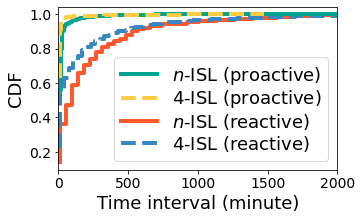

In [18]:
# 绘制时间片间隔
def cal_invertal(r):
    for i in range(len(r)):
        tmp = [(r[i][j] - r[i][j-1]) * 10 for j in range(1, len(r[i]))]
        r[i] = tmp
        print("time interval: ", min(r[i]), np.mean(r[i]), max(r[i]))
    
    # cdf
    fig = plt.figure(figsize=(5, 3))
    font2 = {'family' : 'Arial',
    'weight' : 'normal',
    'size'   : 22,
    }
    ecdf, x, y = [], [], []
    for i in range(len(r)):
        ecdf.append(sm.distributions.ECDF(r[i]))
        x.append(np.linspace(min(r[i]), max(r[i]),num=200))
        y.append(ecdf[i](x[i]))
    
    colors = ["#00A491","#FFCD43","#FF592D","#3787C0"]
    lines = ['-', '--', '-', '--']
    # labels = ['limitless isl (np)', '+Grid (np)', 'limitless isl (p)', '+Grid (p)']
    # labels = ["free (aggressive)", "Grid (aggressive)", "free (lazy)", "Grid (lazy)"]
    # labels = ["Sharing (proactive)", "Grid (proactive)", "Sharing (reactive)", "Grid (reactive)"]
    labels = ["$n$-ISL (proactive)", "$4$-ISL (proactive)", "$n$-ISL (reactive)", "$4$-ISL (reactive)"]

    right=2000
    plt.xlim(-0.05,right)
    plt.xlabel("Time interval (minute)", fontsize = 18)
    plt.ylabel("CDF", fontsize = 18)
    plt.tick_params(labelsize=14)
    
    for i in range(len(r)):
        print(x[i][:10], y[i][:10])
        plt.step(x[i], y[i], lines[i], linewidth=4, color=colors[i], label=labels[i]) # color=colors[i], 
    
    plt.plot([x[0][-1],right],[1,1],lines[0],color=colors[0],linewidth=4)
    plt.plot([x[1][-1],right],[1,1],lines[1],color=colors[1],linewidth=4)
    # plt.plot([x_h[-1],right],[1,1],'-',color=color,linewidth=4)
      
    plt.legend(frameon=True, fontsize=18, loc=4, labelspacing=0.1)# ,labelspacing=0.1,columnspacing=0.4,ncol=2,loc=3,bbox_to_anchor=(0.032,0.001))  # ,bbox_to_anchor=(0.33,0.82) bbox_to_anchor=(0.73,0.92) bbox_to_anchor=(1.03,0.82)
    save_path = "/Users/liulixin/Desktop/Tsinghua/Seafile/debris/papers/mobicom23-submission/figures/"
    plt.savefig("all_snapshot_interval_v2.pdf",dpi=300,bbox_inches = 'tight')
    plt.show()
cal_invertal([snap_lnp, snap_gnp, snap_lp, snap_gp])